# Customer Segmentation

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append("code/.")
import matplotlib.pyplot as plt
# import mglearn
import seaborn as sns
from sklearn import cluster, datasets, metrics
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# plt.style.use("seaborn")
%matplotlib inline

/var/folders/8y/0jg6xk414_dbq8h836jpwq1h0000gn/T/ipykernel_66928/63394261.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<br>


# 1. EDA

In [2]:
df = pd.read_csv("data/CC General.csv")
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Data Dictionary:
<br>
- CUST_ID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases 
- BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFF_PURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTS_PURCHASES : Amount of purchase done in installment
- CASH_ADVANCE : Cash in advance given by the user
- PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASES_TRX : Numbe of purchase transactions made
- CREDIT_LIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

In [3]:
# Check the shape of df:
df.shape

(8950, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

- there are some null values under CREDIT_LIMIT and MINIMUM_PAYMENTS
- all features are numeric except for cust_id

In [5]:
df.describe()


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Few things to note:
- Average Balance is $1564.47
- Maximum one off purchase was $40761.25
- Maximum credit limit is $30000
- Maximum number of transaction made was 358



In [6]:
# find the customer who received the maximium cash advance:
max_cash_advance = df["CASH_ADVANCE"].max()
df[df["CASH_ADVANCE"] == max_cash_advance]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12


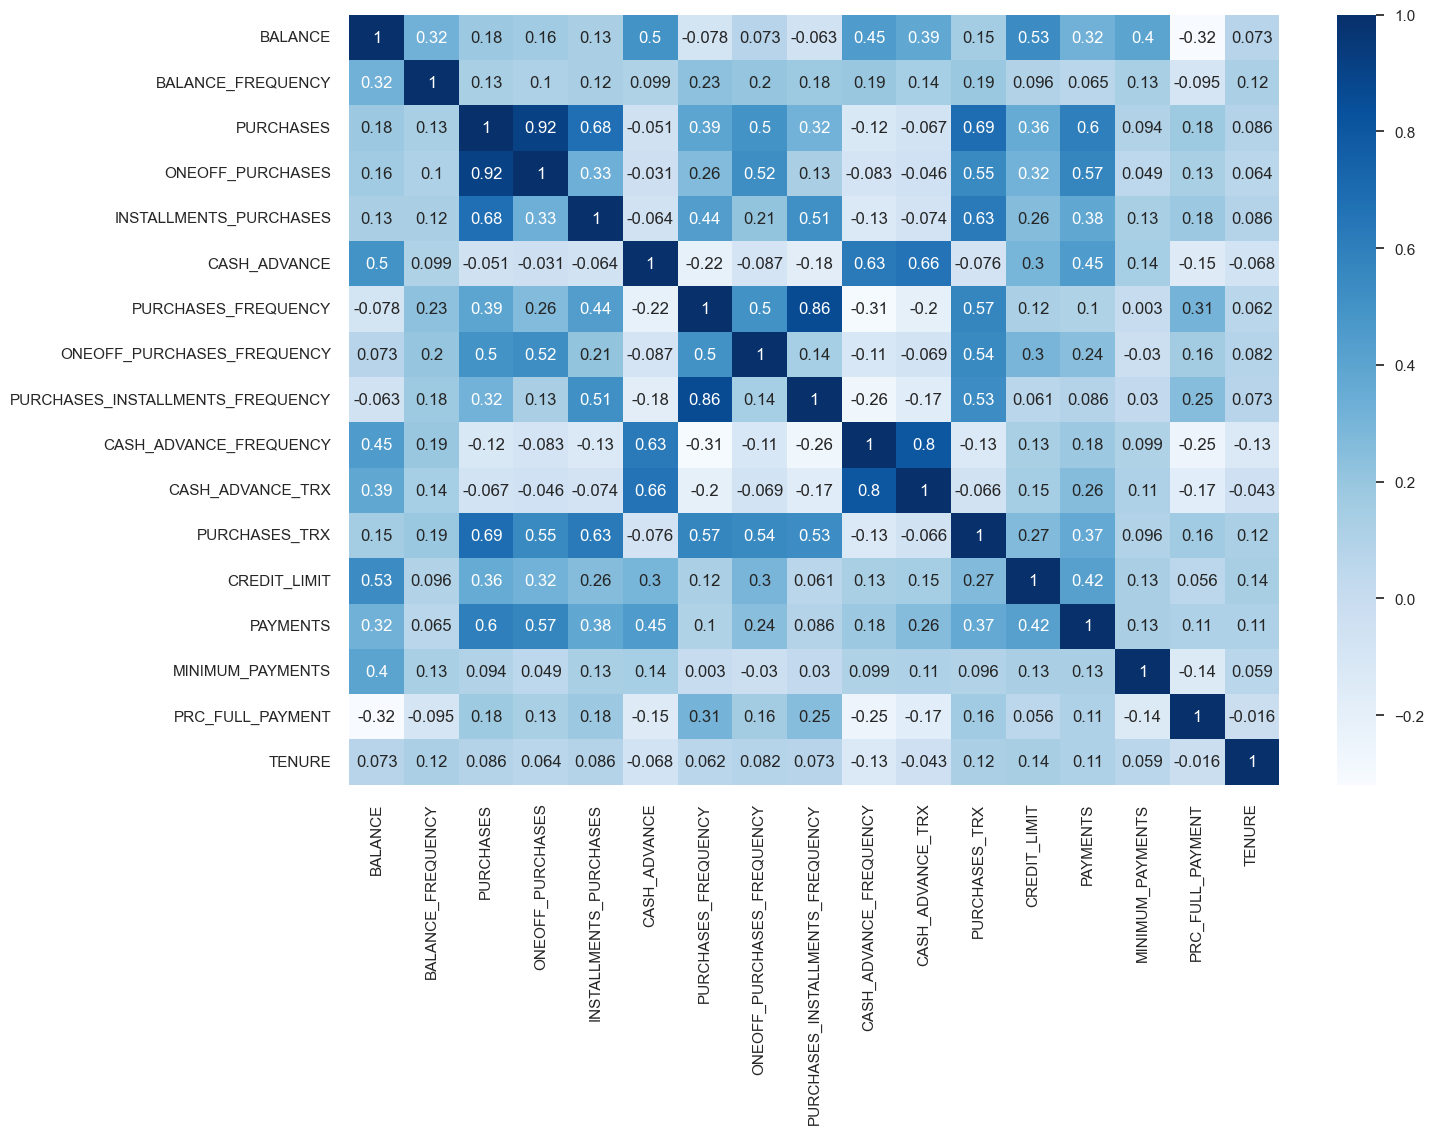

In [7]:
# look at the correlation between features:
cor_df = df.drop(columns=['CUST_ID'])
cor = cor_df.corr()
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

<br>

# 2. Preprocessing

In [8]:
drop_features = ["CUST_ID"]
numeric_features = list(set(df.columns) - set(drop_features))

Apply simple imputer for missing values and standard scaler for numeric features:

In [9]:
from sklearn.impute import SimpleImputer

numeric_transformer = make_pipeline(SimpleImputer(), StandardScaler())

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features), ("drop", drop_features)
)

In [10]:
transformed_df = pd.DataFrame(
    data=preprocessor.fit_transform(df), columns=numeric_features
)

Preprocessed df:

In [11]:
transformed_df

,CASH_ADVANCE,ONEOFF_PURCHASES,CASH_ADVANCE_FREQUENCY,PRC_FULL_PAYMENT,PURCHASES,ONEOFF_PURCHASES_FREQUENCY,TENURE,PURCHASES_FREQUENCY,CASH_ADVANCE_TRX,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,PAYMENTS,BALANCE,BALANCE_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CREDIT_LIMIT,PURCHASES_TRX
0,-0.466786,-0.356934,-0.675349,-0.525551,-0.424900,-0.678661,0.360680,-0.806490,-0.476070,-0.349079,-3.109675e-01,-0.528979,-0.731989,-0.249434,-0.707313,-0.960433,-0.511333
1,2.605605,-0.356934,0.573963,0.234227,-0.469552,-0.678661,0.360680,-1.221758,0.110074,-0.454576,8.931021e-02,0.818642,0.786961,0.134325,-0.916995,0.688639,-0.591796
2,-0.466786,0.108889,-0.675349,-0.525551,-0.107668,2.673451,0.360680,1.269843,-0.476070,-0.454576,-1.016632e-01,-0.383805,0.447135,0.518084,-0.916995,0.826062,-0.109020
3,-0.368653,0.546189,-0.258913,-0.525551,0.232058,-0.399319,0.360680,-1.014125,-0.329534,-0.454576,4.878305e-17,-0.598688,0.049099,-1.016953,-0.916995,0.826062,-0.551565
4,-0.466786,-0.347294,-0.675349,-0.525551,-0.462063,-0.399319,0.360680,-1.014125,-0.476070,-0.454576,-2.657913e-01,-0.364368,-0.358775,0.518084,-0.916995,-0.905464,-0.551565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.466786,-0.356934,-0.675349,1.183951,-0.333293,-0.678661,-4.122768,1.269843,-0.476070,-0.132643,-3.498541e-01,-0.486217,-0.737950,0.518084,1.179833,-0.960433,-0.350408
8946,-0.466786,-0.356934,-0.675349,-0.525551,-0.329136,-0.678661,-4.122768,1.269843,-0.476070,-0.122823,4.878305e-17,-0.503396,-0.742423,0.518084,1.179833,-0.960433,-0.350408
8947,-0.466786,-0.356934,-0.675349,0.329200,-0.401965,-0.678661,-4.122768,0.854576,-0.476070,-0.294893,-3.354655e-01,-0.570615,-0.740398,-0.185477,0.760469,-0.960433,-0.390639
8948,-0.449352,-0.356934,0.157527,0.329200,-0.469552,-0.678661,-4.122768,-1.221758,-0.182998,-0.454576,-3.469065e-01,-0.580536,-0.745174,-0.185477,-0.916995,-1.097856,-0.591796


<br>

# 3. Modeling

- It is important to find the optimal number of clusers first
- I will try two methods: Elbow method and Silhouette scores

In [12]:
from sklearn.cluster import KMeans
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 20))

- Elbow Method
- Fit the preprocessed df to KElbowVisaulizer
- The optimal number suggested is around 6:

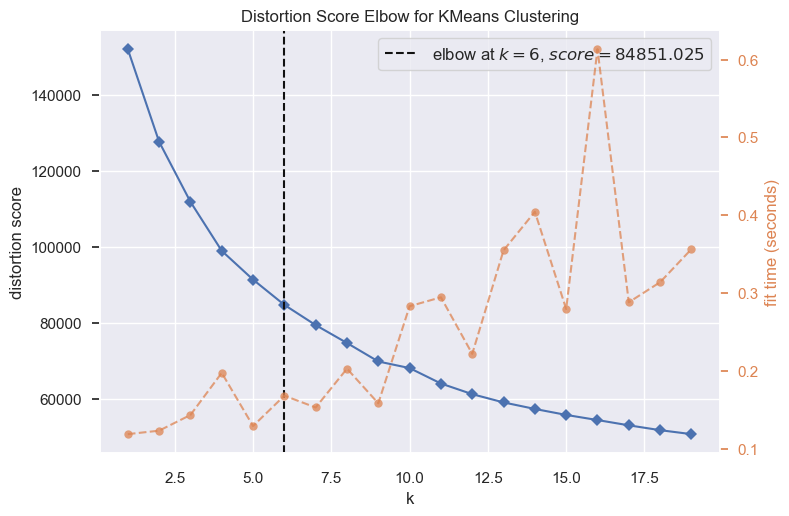

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
visualizer.fit(transformed_df) 
visualizer.show()

- Noting above recommendation, run the Silhoueette Plot with 3-6 cluser centers:

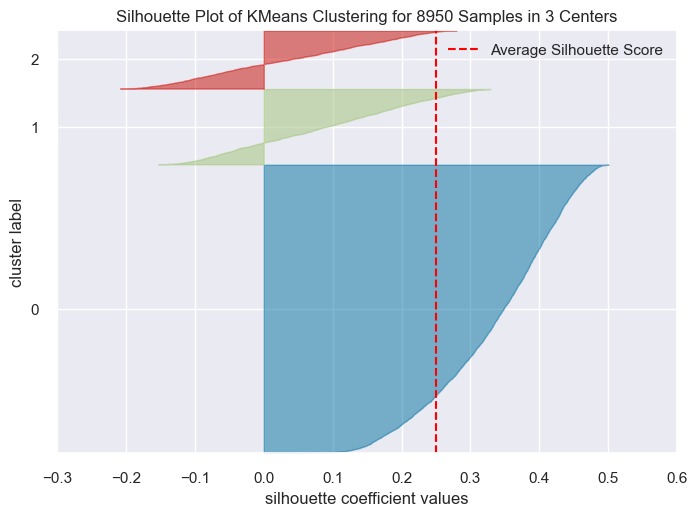

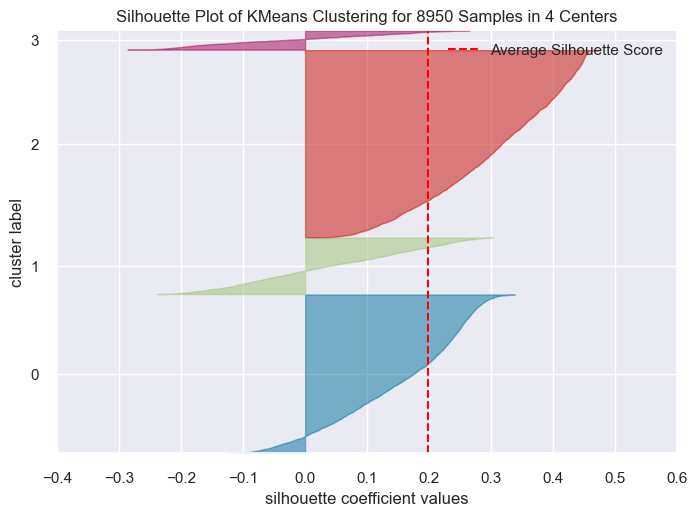

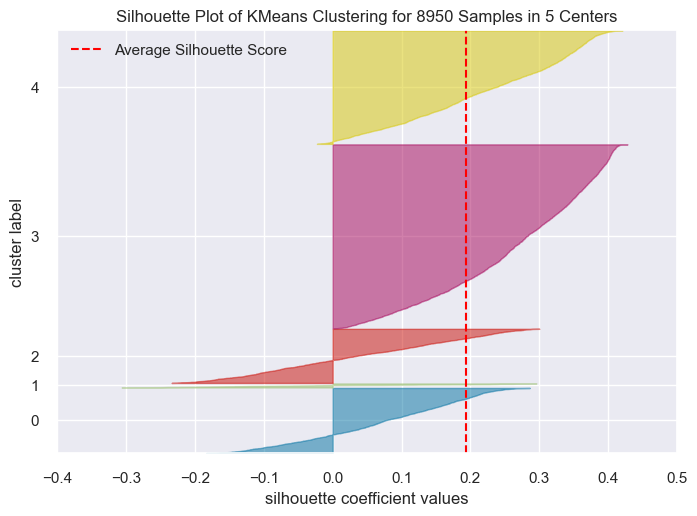

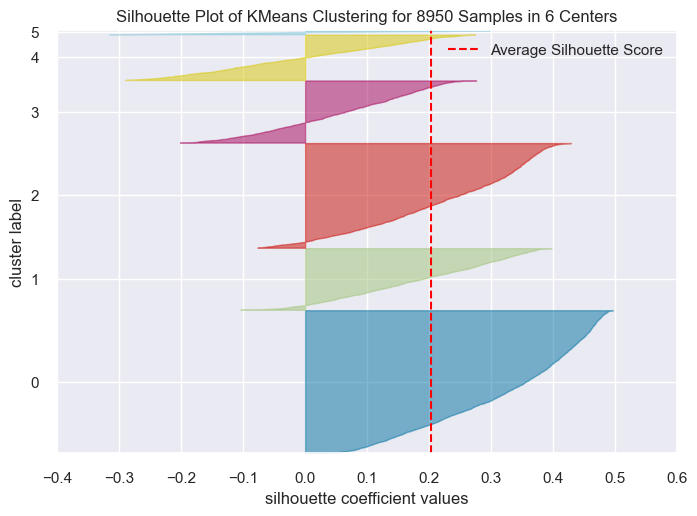

In [14]:
for k in range(3, 7):
    model = KMeans(k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
    visualizer.fit(transformed_df)  # Fit the data to the visualizer
    visualizer.show()

- Silhouette scores are not that high for all scenarios, but based on the distribution of each cluster I am inclined to go ahead with 6 clusters
- Let's check the visualizaitons of clusters as well:

In [15]:
import umap

In [16]:
def plot_umap_clusters(
    data,
    cluster_labels,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        edgecolors="k",
        linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


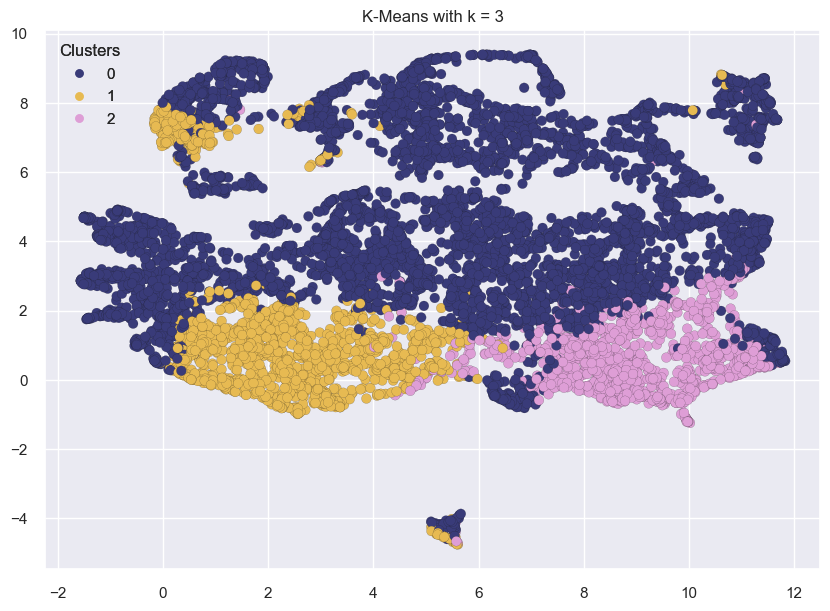

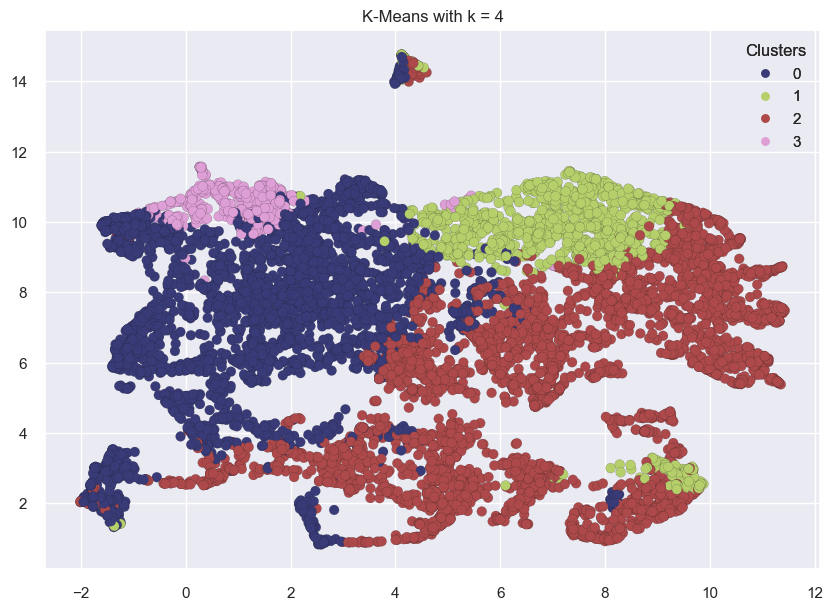

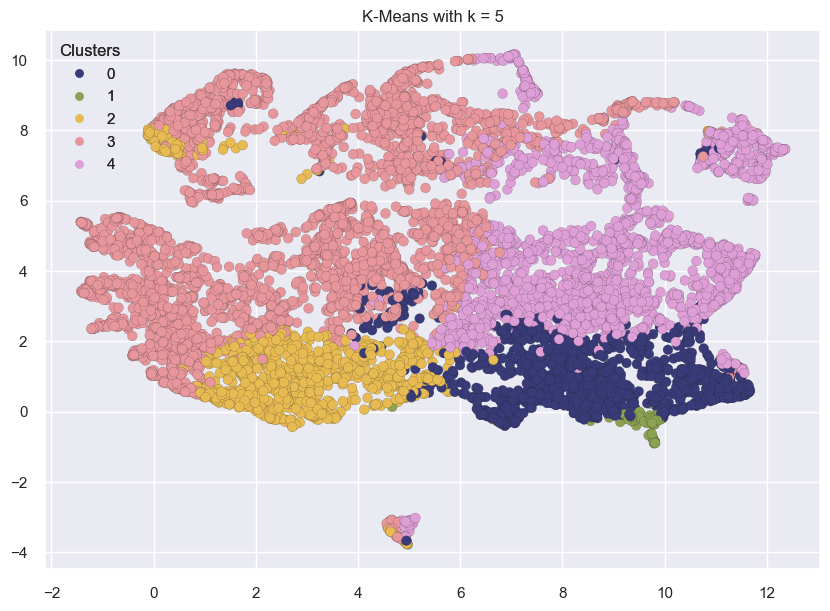

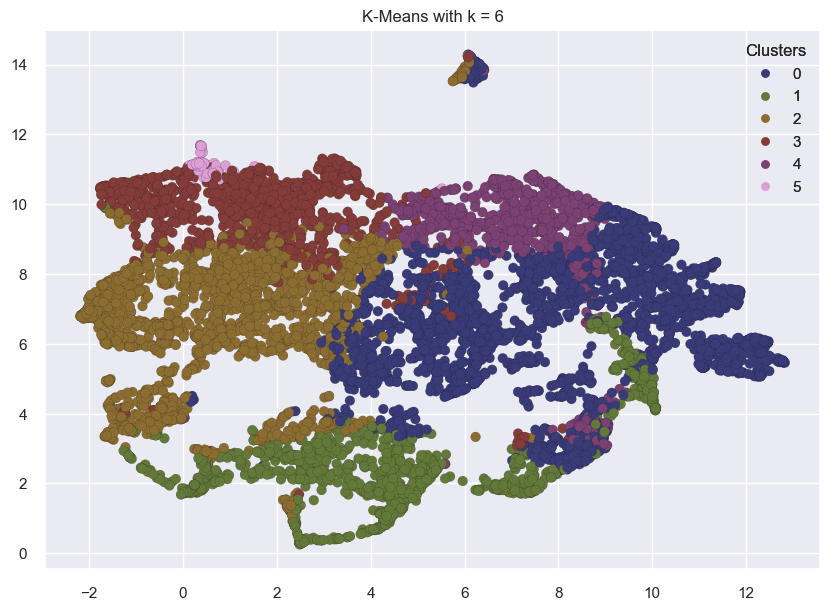

In [17]:

for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed_df)
    labels = kmeans.labels_
    plot_umap_clusters(transformed_df, kmeans.labels_, title=f"K-Means with k = {k}")

- K Means with K=6 seem to be well separated, so will go ahead with 6 centers

In [18]:
reasonable_k = 6
kmeans = KMeans(n_clusters=reasonable_k, random_state=42)
kmeans.fit(transformed_df)
labels = kmeans.labels_

In [19]:
cluster_centers = pd.DataFrame(
    data=kmeans.cluster_centers_, columns=[transformed_df.columns]
)
cluster_centers

,CASH_ADVANCE,ONEOFF_PURCHASES,CASH_ADVANCE_FREQUENCY,PRC_FULL_PAYMENT,PURCHASES,ONEOFF_PURCHASES_FREQUENCY,TENURE,PURCHASES_FREQUENCY,CASH_ADVANCE_TRX,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,PAYMENTS,BALANCE,BALANCE_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CREDIT_LIMIT,PURCHASES_TRX
0,-0.081714,-0.223850,0.131981,-0.451012,-0.345349,-0.335680,-0.008641,-0.826548,-0.028270,-0.405221,-0.029880,-0.262070,-0.010281,0.372121,-0.770855,-0.332477,-0.470705
1,-0.306912,-0.231015,-0.484403,0.261571,-0.313038,-0.418705,-0.165980,-0.560037,-0.357813,-0.315659,-0.256015,-0.221025,-0.697844,-2.121553,-0.465064,-0.209329,-0.425746
2,-0.365854,-0.244767,-0.463438,0.340692,-0.067365,-0.376324,-0.025166,0.964682,-0.358105,0.290363,-0.056038,-0.251488,-0.396865,0.308323,1.139229,-0.329833,0.122143
3,-0.309096,0.877387,-0.405671,0.435885,0.926437,1.838892,0.271440,1.087856,-0.318458,0.578596,-0.024143,0.380207,0.137676,0.427207,0.542908,0.692399,1.184038
4,1.949748,-0.148783,1.901136,-0.391139,-0.204185,-0.183691,-0.089840,-0.449498,1.855405,-0.209546,0.512337,0.776815,1.591479,0.376997,-0.406362,0.963871,-0.244017
5,0.004274,6.244031,-0.299540,0.830765,7.093187,1.867817,0.333341,1.081960,-0.116878,5.297641,1.104788,4.847281,1.443847,0.414656,1.035380,2.171463,4.699112


- We need to reverse the scaling that was applied to better understand each clusters:

In [20]:
data = (
    preprocessor.named_transformers_["pipeline"]
    .named_steps["standardscaler"]
    .inverse_transform(cluster_centers[numeric_features])
)

In [21]:
org_cluster_centers = pd.DataFrame(data=data, columns=numeric_features)
org_cluster_centers = org_cluster_centers.reindex(
    sorted(org_cluster_centers.columns), axis=1
)
org_cluster_centers

,BALANCE,BALANCE_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,MINIMUM_PAYMENTS,ONEOFF_PURCHASES,ONEOFF_PURCHASES_FREQUENCY,PAYMENTS,PRC_FULL_PAYMENT,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,TENURE
0,1543.075446,0.965423,807.512306,0.161555,3.055903,3284.763784,44.631756,794.572431,220.892134,0.102318,974.478117,0.021801,265.361154,0.158617,0.058080,3.009865,11.505755
1,111.971653,0.374694,335.263311,0.038210,0.807018,3732.825243,125.620931,267.574608,209.000465,0.077550,1093.299450,0.230220,334.395004,0.265580,0.179609,4.127384,11.295195
2,738.433679,0.950310,211.658792,0.042405,0.805020,3294.383775,673.638969,733.613272,186.173496,0.090193,1005.110526,0.253361,859.277602,0.877524,0.817196,17.745854,11.483640
3,1851.036530,0.978472,330.682005,0.053965,1.075586,7013.678967,934.284573,807.943042,2048.720612,0.751035,2833.805467,0.281204,2982.551670,0.926960,0.580203,44.140590,11.880574
4,4877.004640,0.966578,5067.584105,0.515581,15.910603,8001.408051,221.578150,2058.187456,345.487536,0.147659,3981.946723,0.039313,566.960000,0.309945,0.202939,8.644491,11.397089
5,4569.720859,0.975499,987.833746,0.075203,2.451220,12395.121951,5201.658537,3438.869446,10956.249146,0.759664,15765.548522,0.396699,16157.907683,0.924593,0.775924,131.512195,11.963415


In [22]:
# Let's look at the most relevant columns:
relevant_cols = [
    "BALANCE",
    "CREDIT_LIMIT",
    "PRC_FULL_PAYMENT",
    "PURCHASES_FREQUENCY",
    "CASH_ADVANCE",
    "CASH_ADVANCE_FREQUENCY",
    "CASH_ADVANCE_TRX",
]
org_cluster_centers[relevant_cols]

,BALANCE,CREDIT_LIMIT,PRC_FULL_PAYMENT,PURCHASES_FREQUENCY,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX
0,1543.075446,3284.763784,0.021801,0.158617,807.512306,0.161555,3.055903
1,111.971653,3732.825243,0.230220,0.265580,335.263311,0.038210,0.807018
2,738.433679,3294.383775,0.253361,0.877524,211.658792,0.042405,0.805020
3,1851.036530,7013.678967,0.281204,0.926960,330.682005,0.053965,1.075586
4,4877.004640,8001.408051,0.039313,0.309945,5067.584105,0.515581,15.910603
5,4569.720859,12395.121951,0.396699,0.924593,987.833746,0.075203,2.451220


<br>

# 4. Interpretation

- Based on above result, we can name each cluster using distinct qualities
- For ex: Cluster 1 has low balance amount left to make purchases 
- Cluster 5 has the highest credit limit and highest percent of pull payment paid 
- Cluster 4 has highest cash in advance amount and cash in advance frequency
- Cluster 2 and 3 has high purchase frequencies but very different credit limit <br>

**I will make simple classifications as follows:** 
- **Cluster 0: Red-Flags** - users with medium credit limit but does not pay off their purchases in full
- **Cluster 1: Low-activity** - users with medium credit limit but low purchase frequency
- **Cluster 2: Regulars** - users with medium credit limit and high purchase frequency
- **Cluster 3: T2 VIP** - users who have fairly high credit limit and and actively uses the card
- **Cluster 4: Cash-Advance** - users who have high balance and limit but uses cash in advance instead
- **Cluster 5: T1 VIP** - users who have high credit limit and actively uses the card

In [23]:
cluster_labels = {0: "Red-Flag", 1: "Low-Activity", 2: "Regulars", 3: "T2VIP", 4:"Cash-Advance", 5:"T1VIP"}

- Double check with distributions for some of important columns, which align with reasons I have used to make cluster labels:

In [24]:
df['cluster'] = labels

In [25]:
def show_hists(df=df, cols=["BALANCE", "CASH_ADVANCE", "PRC_FULL_PAYMENT", "PURCHASES_FREQUENCY"]):
    for i in cols:
        plt.figure(figsize=(35, 5))
        for j in range(6):
            plt.subplot(1, 6, j + 1)
            cluster = df[df["cluster"] == j]
            cluster[i].hist(bins=20)
            plt.title(f"{i}    \nCluster: {cluster_labels[j]} ")

        plt.show()

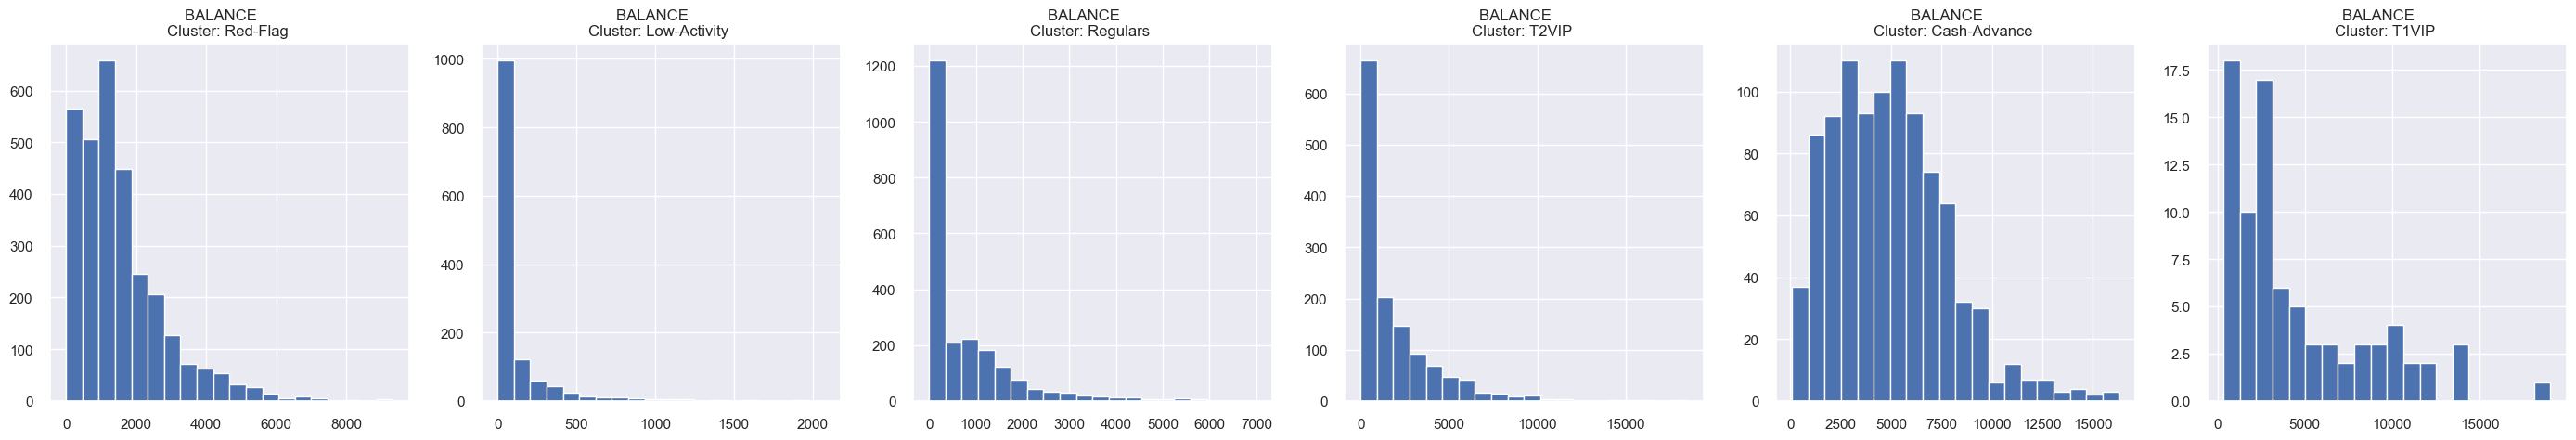

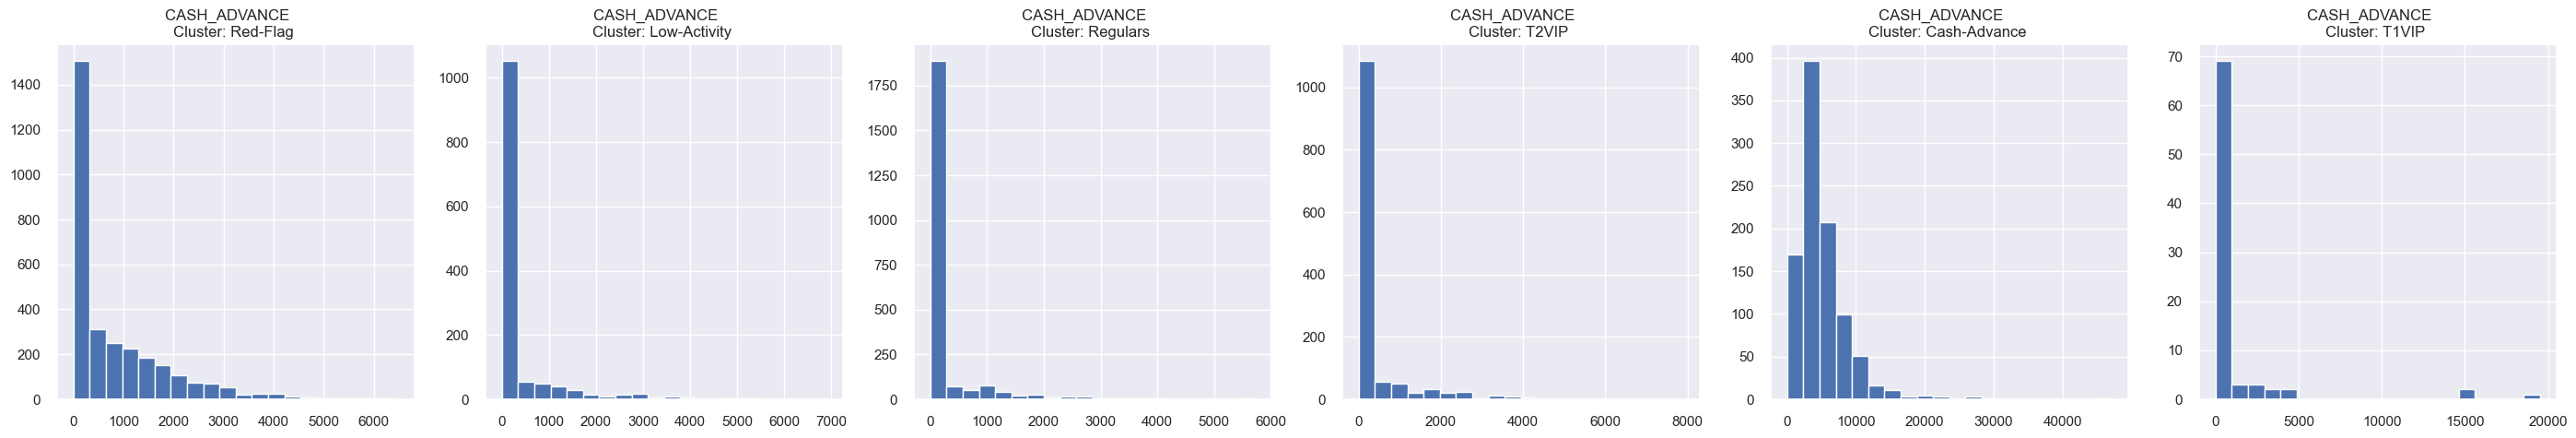

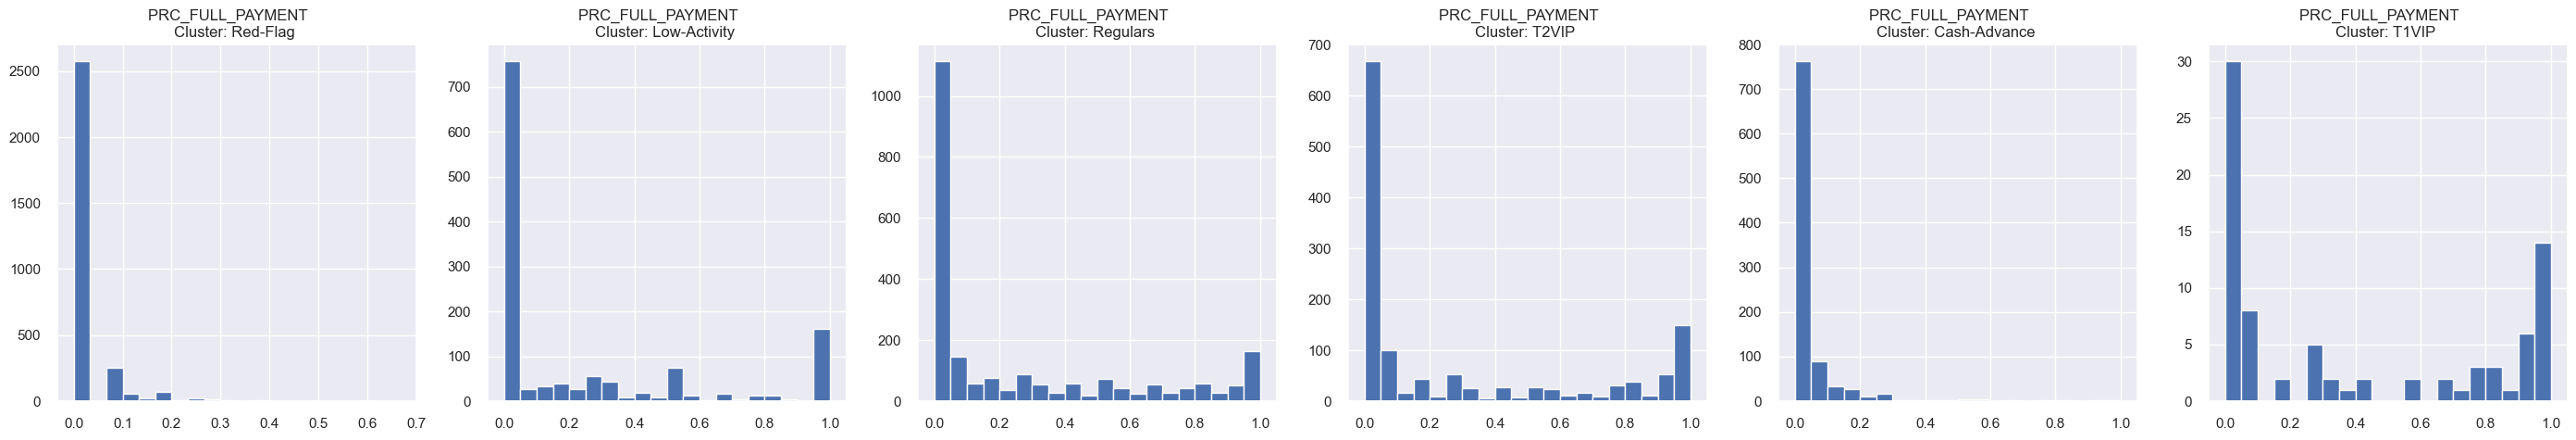

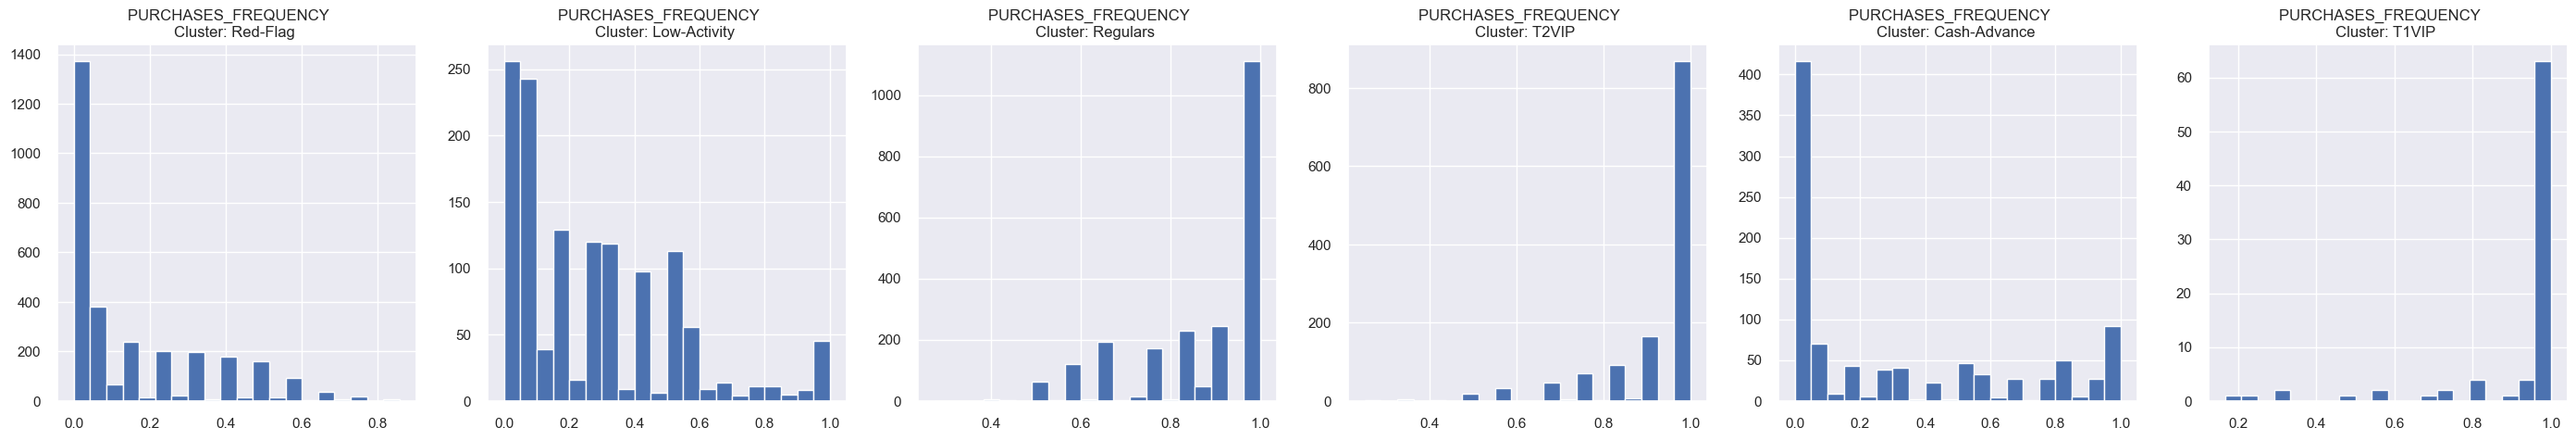

In [26]:
show_hists()